<a href="https://colab.research.google.com/github/Kim-Jeong-Ju/AI_Modeling_NLP/blob/main/Word_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Packages and Modules Importation**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import time
import re
import urllib.request
from urllib.request import urlretrieve, urlopen
import zipfile
import gzip
import pickle
from tqdm import tqdm
from lxml import etree

import numpy as np
import pandas as pd
from math import log
import matplotlib.pyplot as plt

import gensim
from gensim.models import Word2Vec, KeyedVectors, FastText

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences, skipgrams
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Embedding, Reshape, Activation, Input, Dot, Flatten
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

!pip install konlpy
from konlpy.tag import Okt

!pip install glove_python_binary
from glove import Corpus, Glove

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Word Embedding, 워드 임베딩**

## **영어/한국어 Word2Vec Generation**  


---

XML 형태의 Training Data를 전처리하여 **자연어로 변환**하는 작업 필요. `<content>` tag 내의 내용을 parsing하여 가져와야 함. Laughter와 Applause와 같은 배경음 역시 제거하는 전처리 작업 필요

### **영어 Word2Vec Generation**

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

start_time = time.time()
targetXML = open("ted_en-20160408.xml", "r", encoding="UTF8")
target_text = etree.parse(targetXML)
parse_text = "\n".join(target_text.xpath("//content/text()"))

content_text = re.sub(r'\([^)]*\)', '', parse_text)             # https://uipath.tistory.com/91 참조
sent_text = sent_tokenize(content_text)                         # NLTK 문장 토큰화 수행

normalized_text = []
for string in sent_text:
    tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
    normalized_text.append(tokens)

result = [word_tokenize(sentence) for sentence in normalized_text]
print('Total Sample Length = {}'.format(len(result)))
print("Execution Time =", time.time() - start_time)

with open('ted_en-20160408_token.pkl', 'wb') as file:           # XML 데이터를 tokenize하는데 시간이 많이 필요하므로 토큰화된 list를 pickle 파일로 저장
    pickle.dump(result, file)
with open('ted_en-20160408_token.pkl', 'rb') as file:           # 저장한 XML 데이터에 대한 토큰화 pickle 파일 불러오기 
    result = pickle.load(file)

for line in result[:3]:                                         # 불러온 데이터의 sample 3개 출력
    print(line)

Total Sample Length = 273380
Execution Time = 4722.625554561615
['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


**Word2Vec의 arguments**  
- **sentence :** 단어 -> 벡터로 변환할 문장 입력
- **size :** 단어 벡터의 특징값, 임베딩된 벡터의 차원
- **window :** context window의 크기
- **min_count :** 단어 최소 빈도수 제한 -> 빈도수가 적은 단어들은 학습 X
- **workers :** 학습을 위한 process 수
- **sg :** 0이면 CBOW, 1이면 Skip-gram

In [ ]:
model = Word2Vec(sentences=result, size=100, window=5, min_count=5, workers=4, sg=0)

model_result = model.wv.most_similar("man")
print(model_result)
print()

model.wv.save_word2vec_format("ENG_w2v")                        # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("ENG_w2v")     # 모델 로드
loaded_result = loaded_model.most_similar("man")
print(loaded_result)

[('woman', 0.8404335379600525), ('guy', 0.8093708157539368), ('boy', 0.7701140642166138), ('lady', 0.7535463571548462), ('soldier', 0.7397874593734741), ('gentleman', 0.7388907670974731), ('girl', 0.735160231590271), ('kid', 0.6878196597099304), ('poet', 0.6819333434104919), ('smith', 0.6629151105880737)]

[('woman', 0.8404335379600525), ('guy', 0.8093708157539368), ('boy', 0.7701140642166138), ('lady', 0.7535463571548462), ('soldier', 0.7397874593734741), ('gentleman', 0.7388907670974731), ('girl', 0.735160231590271), ('kid', 0.6878196597099304), ('poet', 0.6819333434104919), ('smith', 0.6629151105880737)]


### **한국어 Word2Vec Generation**

         id                                           document  label
0   8112052                                어릴때보고 지금다시봐도 재밌어요ㅋㅋ      1
1   8132799  디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...      1
2   4655635               폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.      1
3   9251303  와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...      1
4  10067386                        안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.      1
200000
True

False
199992



<ipython-input-4-0c6cf18d3ef0>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data["document"] = train_data["document"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")


         id                                           document  label
0   8112052                                어릴때보고 지금다시봐도 재밌어요ㅋㅋ      1
1   8132799  디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...      1
2   4655635                   폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고      1
3   9251303   와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지      1
4  10067386                         안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화      1


Eliminating Stopwords...: 100%|██████████| 199992/199992 [22:56<00:00, 145.25it/s]


Execution Time = 1379.6876459121704

Max Length of Movie Review = 72
Avg Length of Movie Review = 10.716703668146726


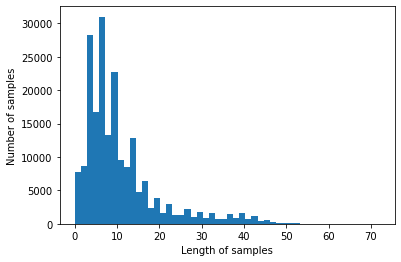

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")
train_data = pd.read_table("ratings.txt")
print(train_data.head())
print(len(train_data))                          # 전체 영화 리뷰 size 출력
print(train_data.isnull().values.any())         # NULL과 같은 결측치 확인
print()

train_data = train_data.dropna(how="any")
print(train_data.isnull().values.any())         # NULL과 같은 결측치 재확인
print(len(train_data))                          # 전체 영화 리뷰 size 재출력
print()

train_data["document"] = train_data["document"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
print(train_data.head())

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']     # 불용어 제거
start_time = time.time()

okt = Okt()
tokenized_data = []
for sent in tqdm(train_data["document"], desc="Eliminating Stopwords..."):
    tokenized_sent = okt.morphs(sent, stem=True)
    stopwords_removed_sent = [word for word in tokenized_sent if word not in stopwords]
    tokenized_data.append(stopwords_removed_sent)
print("Execution Time =", time.time() - start_time)
print()

print("Max Length of Movie Review =", max(len(review) for review in tokenized_data))
print("Avg Length of Movie Review =", sum(map(len, tokenized_data)) / len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel("Length of samples")
plt.ylabel("Number of samples")
plt.show()

In [ ]:
model = Word2Vec(sentences=tokenized_data, size=100, window=5, min_count=5, workers=4, sg=0)
print(model.wv.vectors.shape)
print(model.wv.most_similar("최민식"))
print(model.wv.most_similar("히어로"))

(16477, 100)
[('한석규', 0.8837981224060059), ('김수현', 0.8669970631599426), ('최민수', 0.8655436635017395), ('안성기', 0.8640116453170776), ('이정재', 0.8534038066864014), ('임원희', 0.843616247177124), ('설경구', 0.8410159349441528), ('박중훈', 0.8410141468048096), ('엄태웅', 0.8379778861999512), ('유다인', 0.8361737132072449)]
[('호러', 0.8738075494766235), ('슬래셔', 0.8629007339477539), ('느와르', 0.8564665913581848), ('무협', 0.8532429933547974), ('무비', 0.8410012722015381), ('블록버스터', 0.8282603025436401), ('물', 0.8112932443618774), ('멜로', 0.8098613023757935), ('물의', 0.8081122636795044), ('블랙', 0.786051869392395)]


### **Pretrained Word2Vec Embedding**  
> 자연어 처리 작업을 할때, 케라스의 Embedding()를 사용하여 갖고 있는 훈련 데이터로부터 처음부터 임베딩 벡터를 훈련시키기도 하지만, 위키피디아 등의 방대한 데이터로 **사전에 훈련된 워드 임베딩(pre-trained word embedding vector)를 가지고 와서 해당 벡터들의 값을 원하는 작업에 사용**할 수도 있음  
>  
> 예를 들어서 감성 분류 작업을 하는데 훈련 데이터의 양이 부족한 상황이라면, **다른 방대한 데이터를 Word2Vec이나 GloVe 등으로 사전에 학습시켜놓은 임베딩 벡터들을 가지고 와서 모델의 입력으로 사용하는 것이 때로는 더 좋은 성능**을 얻을 수 있음  
>  
> 구글이 제공하는 **사전 훈련된(미리 학습되어져 있는) Word2Vec 모델**을 사용. 구글은 **사전 훈련된 3백만 개의 Word2Vec 단어 벡터**들을 제공함. **각 임베딩 벡터의 차원은 300임**

In [ ]:
urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", filename="GoogleNews-vectors-negative300.bin.gz")
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

HTTPError: ignored

## **Negative Samping을 활용한 Word2Vce Generation**

### **Skip-Gram with Negative Sampling, SGNS**  


---


**중심 단어 - 주변 단어의 관계 성립을 위해 1개의 sample에 최소한 2개의 단어가 존재해야 함.** 최소 2개의 단어가 없다면 sample을 구성할 수 없어 error 발생함. 이를 만족하지 않는 sample들은 제거하는 작업 필요

In [ ]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=("headers", "footers", "quotes"))
documents = dataset.data
print("Total Sample Size =", len(documents))
print()

news_df = pd.DataFrame({"document" : documents})
news_df["clean_doc"] = news_df["document"].str.replace("[^a-zA-Z]", " ")                                                    # 특수문자 제거
news_df["clean_doc"] = news_df["clean_doc"].apply(lambda x:" ".join([word for word in x.split() if len(word) > 3]))         # 길이가 3 이하인 짧은 단어 제거
news_df["clean_doc"] = news_df["clean_doc"].apply(lambda x: x.lower())                                                      # 소문자화
print(news_df.head())
print(news_df.isnull().values.any())            # 결측치 확인
print()

news_df.replace("", float("NaN"), inplace=True)
print(news_df.isnull().values.any())            # 결측치 재확인
news_df.dropna(inplace=True)
print("Total Sample Size =", len(news_df))
print()

stop_words = nltk.corpus.stopwords.words("english")         # 불용어 제거
tokenized_doc = news_df["clean_doc"].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()
print(np.shape(tokenized_doc))
print()

drop_train = [index for index, sent in enumerate(tokenized_doc) if len(sent) <= 1]      # 단어가 1개 이하인 sample을 찾아 제거
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print("Total Sample Size =", len(tokenized_doc))
print()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)
word2idx = tokenizer.word_index
idx2word = {value : key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)
print(encoded[:2])
print()

vocab_size = len(word2idx) + 1
print("Word Vocabulary Size =", vocab_size)

Total Sample Size = 11314



<ipython-input-6-55f10189ad3c>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  news_df["clean_doc"] = news_df["document"].str.replace("[^a-zA-Z]", " ")                                                    # 특수문자 제거


                                            document  \
0  Well i'm not sure about the story nad it did s...   
1  \n\n\n\n\n\n\nYeah, do you expect people to re...   
2  Although I realize that principle is not one o...   
3  Notwithstanding all the legitimate fuss about ...   
4  Well, I will have to change the scoring on my ...   

                                           clean_doc  
0  well sure about story seem biased what disagre...  
1  yeah expect people read actually accept hard a...  
2  although realize that principle your strongest...  
3  notwithstanding legitimate fuss about this pro...  
4  well will have change scoring playoff pool unf...  
False

True
Total Sample Size = 10995



/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


(10995,)

Total Sample Size = 10940

[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]

Word Vocabulary Size = 64277


In [ ]:
start_time = time.time()

skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]     # Negative Sampling
print("Execution Time =", time.time() - start_time)
print(np.array(skip_grams).shape)
print()

pairs, labels = skip_grams[0][0], skip_grams[0][1]          # 첫번째 sample인 skip_grams[0] 내의 skipgrams로 형성된 dataset 확인
print("Shape of Pairs, Labels =", np.array(pairs).shape, np.array(labels).shape)
print()

for i in range(10):
    print("{:s}({:d})  |  {:s}({:d})  ==>  {:d}".format(idx2word[pairs[i][0]], pairs[i][0], idx2word[pairs[i][1]], pairs[i][1], labels[i]))
print()

pairs, labels = skip_grams[1][0], skip_grams[1][1]          # 첫번째 sample인 skip_grams[0] 내의 skipgrams로 형성된 dataset 확인
print("Shape of Pairs, Labels =", np.array(pairs).shape, np.array(labels).shape)
print()

for i in range(10):
    print("{:s}({:d})  |  {:s}({:d})  ==>  {:d}".format(idx2word[pairs[i][0]], pairs[i][0], idx2word[pairs[i][1]], pairs[i][1], labels[i]))
print()

Execution Time = 0.06290721893310547
(10, 2)

Shape of Pairs, Labels = (2220, 2) (2220,)

media(702)  |  occured(4294)  ==>  1
received(634)  |  monsarrat(19945)  ==>  0
clearly(661)  |  atrocities(4406)  ==>  1
lived(1148)  |  unwrapped(41978)  ==>  0
acts(1102)  |  articles(829)  ==>  0
daily(1920)  |  think(6)  ==>  1
europeans(4520)  |  whole(217)  ==>  1
makes(228)  |  acts(1102)  ==>  1
seem(207)  |  skys(34615)  ==>  0
shame(4988)  |  learned(1845)  ==>  0

Shape of Pairs, Labels = (1380, 2) (1380,)

atheism(800)  |  streamflow(60409)  ==>  0
chewables(33570)  |  forget(985)  ==>  1
atheism(800)  |  faith(333)  ==>  1
feelings(2700)  |  maybe(146)  ==>  1
hard(107)  |  runs(421)  ==>  1
much(13)  |  happily(7262)  ==>  1
happily(7262)  |  sorry(458)  ==>  1
ever(186)  |  well(9)  ==>  1
ever(186)  |  willie(6920)  ==>  0
feelings(2700)  |  gaetz(28101)  ==>  0



<ipython-input-7-d6987838b1d5>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(skip_grams).shape)


Window 크기 내에서, 각각의 뉴스 그룹 sample에 대해 동일한 프로세스 수행  
- 중심 단어 - 주변 단어의 관계를 갖는 경우 **label=1**
- 그렇지 않은 경우 **label=0**

In [ ]:
print("Total Sample Size =", len(skip_grams))

pairs, labels = skip_grams[0][0], skip_grams[0][1]
print("첫번째 paris =", len(pairs))
print("첫번째 paris =", len(pairs))
print()

pairs, labels = skip_grams[1][0], skip_grams[1][1]
print("두번째 paris =", len(pairs))
print("두번째 paris =", len(pairs))
print()

start_time = time.time()
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]      # 모든 뉴스 그룹에 대해 Negative Sampling 수행
print("Execution Time =", time.time() - start_time)
print("Total Sample Size =", len(skip_grams))

Total Sample Size = 10
첫번째 paris = 2220
첫번째 paris = 2220

두번째 paris = 1380
두번째 paris = 1380

Execution Time = 161.46300625801086
Total Sample Size = 10940


In [ ]:
embedding_dim = 100

## 중심 단어를 위한 Embedding Table
w_inputs = Input(shape=(1, ), dtype="int32")                        # Input이 one hot 인코딩이 아니라 정수 인코딩, input_length=1 => shape=(1,)
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)     # Embedding()은 (number of samples, input_length)인 2D 정수 텐서를 입력받아 
                                                                    # (number of samples, input_length, embedding word dimentionality)인 3D float tensor 리턴

## 주변 단어를 위한 Embedding Table
c_inputs = Input(shape=(1, ), dtype="int32")
context_embedding = Embedding(vocab_size, embedding_dim)(c_inputs)
print(word_embedding.shape, context_embedding.shape)
print()

dot_prod = Dot(axes=2)([word_embedding, context_embedding])
dot_prod = Reshape((1, ), input_shape=(1, 1))(dot_prod)
output = Activation("sigmoid")(dot_prod)
model = Model(inputs=[w_inputs, c_inputs], outputs=output)

model.summary()
model.compile(loss="binary_crossentropy", optimizer="adam")
plot_model(model, show_shapes=True, show_layer_names=True)

start_time = time.time()
for epoch in range(1, 6):
    loss = 0

    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype="int32")            # skip_grams에서 elem[0] = pairs, elem[1] = label
        second_elem = np.array(list(zip(*elem[0]))[1], dtype="int32")
        labels = np.array(elem[1], dtype="int32")

        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X, Y)
    
    print(f"Epoch = {epoch}/5  |  Loss = {loss}  |  Time = {time.time() - start_time}")

(None, 1, 100) (None, 1, 100)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       6427700     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       6427700     ['input_2[0][0]']                
                                                               

In [ ]:
## 실행 시간이 긴 관계로 학습된 모델을 별도로 저장
model.save("./model/SGNS.h5")

if os.path.exists("./model/SGNS.h5"):
    model = load_model("./model/SGNS.h5")
else:
    print("trained SGNS Model is not found")


## 학습된 embedding vector들을 vector.txt에 저장 후 genism 패키지를 통해 로드하여 손쉽게 단어 벡터 간 유사도 구하기
file = open("./model/vector.txt", "w")

file.write("{} {}\n".format(vocab_size - 1, embedding_dim))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    file.write("{} {}\n".format(word, " ".join(map(str, list(vectors[i, :])))))

file.close()

w2v = gensim.models.KeyedVectors.load_word2vec_format("./model/vector.txt", binary=False)
print(w2v.most_similar(positive=["soldiers"]))
print()
print(w2v.most_similar(positive=["doctor"]))
print()
print(w2v.most_similar(positive=["police"]))
print()
print(w2v.most_similar(positive=["knife"]))
print()
print(w2v.most_similar(positive=["engine"]))

[('troops', 0.8278371691703796), ('aviv', 0.8211274147033691), ('slaughtered', 0.8209096193313599), ('bombing', 0.8201167583465576), ('shelling', 0.8199048042297363), ('wounded', 0.8185893893241882), ('massacre', 0.8118721842765808), ('villages', 0.8063041567802429), ('massacred', 0.7978286743164062), ('azerbaijani', 0.7977402210235596)]

[('disease', 0.654930830001831), ('lyme', 0.6340230107307434), ('pain', 0.624247670173645), ('infection', 0.5998868942260742), ('quack', 0.5956388711929321), ('clinic', 0.5894120931625366), ('symptoms', 0.5761964917182922), ('physician', 0.5554652214050293), ('yeast', 0.5554440021514893), ('systemic', 0.5554143190383911)]

[('officers', 0.6939032077789307), ('unconstitutional', 0.6538252830505371), ('congress', 0.6325280070304871), ('enforcement', 0.6264446973800659), ('officials', 0.623386800289154), ('ruled', 0.6106305122375488), ('homicides', 0.5940735340118408), ('psychological', 0.5920382142066956), ('nuclear', 0.591476321220398), ('possession', 

## **Topic Modeling(토픽 모델링) and LSA(Latent Semantic Analysis, 잠재 의미 분석)**



---

#### **SVD(Singular Value Decomposition, 특이값 분해)**  
- full SVD란 m x n matrix A에 대하여 다음과 같이 3개의 행렬의 곱으로 분해하는 방법  
$$A=UΣV^\text{T}$$  
- truncated SVD란 full SVD로부터 얻은 3개의 행렬에서 일부 vector를 삭제하여 차원을 축소하는 방식  
(https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)  
  
#### **LSA(Latent Semantic Analysis, 잠재 의미 분석)**  
- 기존의 DTM과 TF-IDF의 단점을 보완하여 truncated SVD를 사용해 단어의 잠재적인 의미를 추가적으로 부여한 개선된 방식의 DTM

In [ ]:
docs = [
  '먹고 싶은 사과',
  '먹고 싶은 바나나',
  '길고 노란 바나나 바나나',
  '저는 과일이 좋아요'
] 
vocab = list(set(word for doc in docs for word in doc.split()))
vocab.sort()
N = len(docs)

def tf(term, doc):
    return doc.count(term)

result = []
for a in range(N):
    result.append([])
    doc = docs[a]
    for b in range(len(vocab)):
        term = vocab[b]
        result[-1].append(tf(term, doc))

tf_pandas = pd.DataFrame(result, columns=vocab)
tf_pandas

,과일이,길고,노란,먹고,바나나,사과,싶은,저는,좋아요
0,0,0,0,1,0,1,1,0,0
1,0,0,0,1,1,0,1,0,0
2,0,1,1,0,2,0,0,0,0
3,1,0,0,0,0,0,0,1,1


In [ ]:
news_dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = news_dataset.data
print('# of samples=',len(documents))
print(news_dataset.target_names)
print()

news_df = pd.DataFrame({'document' : documents})
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")                                        # 특수 문자 제거
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))       # 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())                                          # 전체 단어에 대한 소문자 변환

stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])                   # 불용어 제거

detokenized_doc = []                                                                                            # TF-IDF는 토큰화되어있지 않은 text를 사용하므로 역토큰화 진행
for i in range(len(news_df)):
    term = " ".join(tokenized_doc[i])
    detokenized_doc.append(term)
news_df['clean_doc'] = detokenized_doc

vectorizer = TfidfVectorizer(stop_words="english", max_features=1000, max_df=0.5, smooth_idf=True)              # 상위 1000개의 단어로만 TF-IDF 행렬 생성
X = vectorizer.fit_transform(news_df['clean_doc'])
print("TF-IDF matrix size =", X.shape)
print()

svd_model = TruncatedSVD(n_components=20, algorithm="randomized", n_iter=100, random_state=122)                 # Topic Modeling by Truncated SVD
svd_model.fit(X)
print(np.shape(svd_model.components_))
print()

def get_topics(components, feature_names, n=5):                                                                 # 20개의 row와 1000개의 column 에서 값이 가장 큰 5개를 찾아 단어로 출력
    for idx, topic in enumerate(components):
        print("Topic %d : " % (idx + 1), [(feature_names[i], topic[i].round(5)) for i in topic.argsort()[:-n - 1:-1]])

terms = vectorizer.get_feature_names()
get_topics(svd_model.components_, terms)

# of samples= 11314
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']



<ipython-input-12-ffd97137531b>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")                                        # 특수 문자 제거


TF-IDF matrix size = (11314, 1000)

(20, 1000)

Topic 1 :  [('like', 0.21386), ('know', 0.20046), ('people', 0.19293), ('think', 0.17805), ('good', 0.15128)]
Topic 2 :  [('thanks', 0.32888), ('windows', 0.29088), ('card', 0.18069), ('drive', 0.17455), ('mail', 0.15111)]
Topic 3 :  [('game', 0.37064), ('team', 0.32443), ('year', 0.28154), ('games', 0.2537), ('season', 0.18419)]
Topic 4 :  [('drive', 0.53324), ('scsi', 0.20165), ('hard', 0.15628), ('disk', 0.15578), ('card', 0.13994)]
Topic 5 :  [('windows', 0.40399), ('file', 0.25436), ('window', 0.18044), ('files', 0.16078), ('program', 0.13894)]
Topic 6 :  [('chip', 0.16114), ('government', 0.16009), ('mail', 0.15625), ('space', 0.1507), ('information', 0.13562)]
Topic 7 :  [('like', 0.67086), ('bike', 0.14236), ('chip', 0.11169), ('know', 0.11139), ('sounds', 0.10371)]
Topic 8 :  [('card', 0.46633), ('video', 0.22137), ('sale', 0.21266), ('monitor', 0.15463), ('offer', 0.14643)]
Topic 9 :  [('know', 0.46047), ('card', 0.33605), ('chi

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## **GloVe, 글로브**

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/GaoleMeng/RNN-and-FFNN-textClassification/master/ted_en-20160408.xml", filename="ted_en-20160408.xml")

targetXML = open("ted_en-20160408.xml", "r", encoding="UTF8")
target_text = etree.parse(targetXML)
parse_text = "\n".join(target_text.xpath("//content/text()"))                   # XML 파일로부터 <content></content> tag 사이의 내용들만 가져옴
content_text = re.sub(r"\([^)]*\)", "", parse_text)                             # re.sub()를 통해 배경음 부분 (Audio), (Laugther)등 제거
sent_text = sent_tokenize(content_text)                                         # 입력 corpus에 대해 문장 토큰화

normalized_text = []                                                            # 각 문장에 대해 구두점 제거 및 소문자화
for string in sent_text:
    tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
    normalized_text.append(tokens)

result = [word_tokenize(sent) for sent in normalized_text]                      # 각 문장에 대해 단어 토큰화
print("Total Sample size =", len(result))
print()

corpus = Corpus()
corpus.fit(result, window=5)                                                    # 학습에 사용할 동시 등장 행렬 생성, 윈도우 크기=5
glove = Glove(no_components=100, learning_rate=0.05)

glove.fit(corpus.matrix, epochs=20, no_threads=4, verbose=True)                 # corpus.matrix = 동시 등장 행렬
glove.add_dictionary(corpus.dictionary)                                         # corpus 내부에는 dictionary로 저장된 각 단어의 index 정보에 대해 검색을 위해 GloVe 모델에 추가

print(glove.most_similar("man"))
print(glove.most_similar("boy"))
print(glove.most_similar("university"))
print(glove.most_similar("water"))
print(glove.most_similar("physics"))
print(glove.most_similar("muscle"))
print(glove.most_similar("clean"))

KeyboardInterrupt: ignored

## **FastText, 패스트 텍스트**

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

start_time = time.time()

targetXML = open("ted_en-20160408.xml", "r", encoding="UTF8")
target_text = etree.parse(targetXML)
parse_text = "\n".join(target_text.xpath("//content/text()"))                   # XML 파일로부터 <content></content> tag 사이의 내용들만 가져옴
content_text = re.sub(r"\([^)]*\)", "", parse_text)                             # re.sub()를 통해 배경음 부분 (Audio), (Laugther)등 제거
sent_text = sent_tokenize(content_text)                                         # 입력 corpus에 대해 문장 토큰화

normalized_text = []                                                            # 각 문장에 대해 구두점 제거 및 소문자화
for string in sent_text:
    tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
    normalized_text.append(tokens)

result = [word_tokenize(sent) for sent in normalized_text]                      # 각 문장에 대해 단어 토큰화
print("Total Sample size =", len(result))
print("Execution Time =", time.time()-start_time)
print()

### **Word2Vec과 FastText의 비교**

In [ ]:
w2v_model = Word2Vec(sentences=result, size=100, window=5, min_count=5, workers=4, sg=0)
w2v_model.wv.most_similar("electrofishing")

In [ ]:
fasttext_model = FastText(result, size=100, window=5, min_count=5, workers=4, sg=1)
fasttext_model.wv.most_similar("electrofishing")

## **Pre-trained Word Embedding, 사전 학습된 워드 임베딩**

### **Keras Embedding Layer, 케라스 임베딩 층**

In [ ]:
sentences = ["nice great best amazing", "stop lies", "pitiful nerd", "excellent work", "supreme quality", "bad", "highly respectable"]
y_train = [1, 0, 0, 1, 1, 0, 1]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary Size = {vocab_size}")
print()

X_encoded = tokenizer.texts_to_sequences(sentences)
print(f"Encoded X = {X_encoded}")
print()

max_len = max(len(word) for word in X_encoded)
print(f"Maximum Length = {max_len}")
print()

X_train = pad_sequences(X_encoded, maxlen=max_len, padding="post")
y_train = np.array(y_train)
print(X_train)
print()

In [ ]:
embedding_dim = 4

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))
model.summary()
print()
plot_model(model, show_shapes=True)
print()

model.compile(optimizer="adam", loss="binary_crossentropy", metric=["acc"])
model.fit(X_train, y_train, epochs=100, verbose=2)

### **Pre-trained GloVe, 사전 학습된 GloVe의 사용**

In [ ]:
urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", filename="glove.6B.zip")
zip_file = zipfile.ZipFile('glove.6B.zip')
zip_file.extractall() 
zip_file.close()

embedding_dict = dict()

file = open("glove.6B.100d.txt", encoding="utf8")
for line in file:
    word_vector = line.split()
    word = word_vector[0]                                                       # word_vector[0] = word string, word_vector[1:] = embedding vector

    word_vector_arr = np.asarray(word_vector[1:], dtype="float32")              # 100개의 값을 갖는 array로 변환
    embedding_dict[word] = word_vector_arr
file.close()
print(f"# of Embedding Vectors = {len(embedding_dict)}")
print()

embedding_matrix = np.zeros((vocab_size, 100))
print(np.shape(embedding_matrix))
print(tokenizer.word_index.items())
print()

for word, index in tokenizer.word_index.items():
    vector_value = embedding_dict.get(word)                                     # 단어와 mapping되는 사전 학습된 embedding vector
    if vector_value is not None:
        embedding_matrix[index] = vector_value

model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_len, trainable=True))
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))
model.summary()
plot_model(model, show_shapes=True)
print()

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.fit(X_train, y_train, epochs=100, verbose=2)

### **Pre-trained Word2Vec, 사전 학습된 Word2Vec의 사용**

In [ ]:
urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", filename="GoogleNews-vectors-negative300.bin.gz")
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
print(word2vec_model.vectors.shape)         # 모델의 size 확인
print()

embedding_matrix = np.zeros((vocab_size, 300))
print(np.shape(embedding_matrix))
print()

def get_vector(word):
    if word in word2vec_model:
        return word2vec_model[word]
    else:
        return None

for word, index in tokenizer.word_index.items():
    vector_value = get_vector(word)
    if vector_value is not None:
        embedding_matrix[index] = vector_value

model = Sequential()
model.add(Input(shape=(max_len, ), dtype="int32"))
model.add(Embedding(vocab_size, 300, weights=[embeddig_matrix], input_length=max_len, trainable=True))
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.fit(X_train, y_train, epochs=100, verbose=2)